In [1]:
import time
inicio = time.time()

In [2]:
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 1.3 MB/s eta 0:00:00


In [3]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from tabulate import tabulate
from numpy import array
import datetime as dt           # Permite trabajar con fechas

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


# Reducción de dimensiones
from sklearn.decomposition import PCA

# Regresión lineal
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Pretty print
from pprint import pprint

#SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
# Mapie
from mapie.time_series_regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_coverage_score, regression_mean_width_score

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [6]:
# split a univariate sequence into samples
def TrainingSet(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [7]:
#cargar datos desde drive acceso libre
FILEID = "143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Departamentos.zip && rm -rf /tmp/cookies.txt
!unzip Departamentos.zip
!dir

--2023-07-21 23:18:12--  https://docs.google.com/uc?export=download&confirm=t&id=143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM
Resolving docs.google.com (docs.google.com)... 173.194.210.100, 173.194.210.113, 173.194.210.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2spq7f9f5frejre74la8r0ufdfdc7lnk/1689981450000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=7c2b446e-f6d1-4200-9eba-9f8358a83036 [following]
--2023-07-21 23:18:12--  https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2spq7f9f5frejre74la8r0ufdfdc7lnk/1689981450000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=7c2b446e-f6d1-4200-9eba-9f8358a83036
Resolving doc-0o-6k-docs.googleusercontent.com (doc-0o-6k-docs.googleusercontent.com)... 172.253.123.

In [8]:
ls

 Colombia_Demanda_Horaria.xlsx   Departamentos.zip
 Colombia.xlsx                   sample_data/
 D_Departamental_Horaria.xlsx    Todos_Departamentos_Depurado.xlsx
'Demanda_Caribe Ajustado.xlsx'


In [9]:
df1=pd.read_excel('/content/Colombia_Demanda_Horaria.xlsx')

In [10]:
df1 = df1.drop('Date', axis=1)
# Se establese nuevamente en el indice temporal en la nueva variable 'a', y al DataFrame se incliye la informacion de frecuencia horaria 'H' de la base de datos
date_rng = pd.date_range(start='2000-01-01', end='2023-01-01', freq='H')
# Establece el índice del DataFrame a las fechas generadas
df1.set_index(date_rng[0:-1], inplace=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201624 entries, 2000-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Demand  201624 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

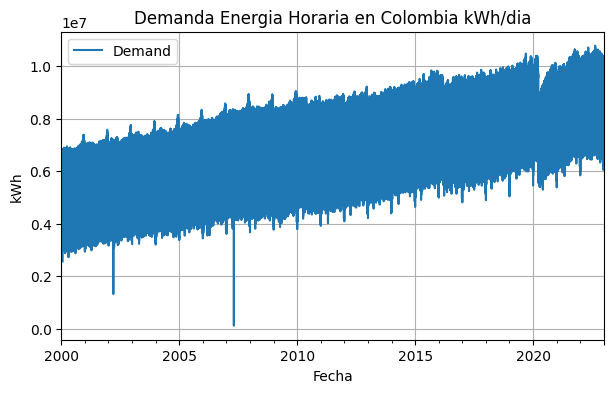

In [12]:
df1.plot(kind='line',figsize=(7,4),title='Demanda Energia Horaria en Colombia kWh/dia', grid=True, ylabel='kWh', xlabel='Fecha',xlim=('2000-01-01','2022-12-31'))

<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

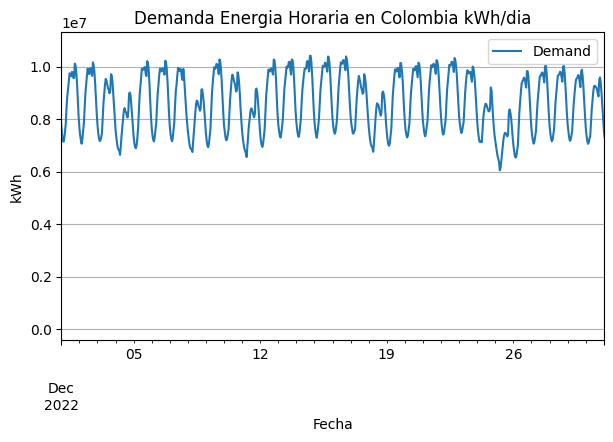

In [13]:
df1.plot(kind='line',figsize=(7,4),title='Demanda Energia Horaria en Colombia kWh/dia', grid=True, ylabel='kWh', xlabel='Fecha',xlim=('2022-12-01','2022-12-31'))

In [14]:
Ts1=df1['2022-01-01':'2022-12-31'].values # Un año
print('Tamaño Serie Horaria: ', len(Ts1))

Tamaño Serie Horaria:  8760


In [15]:
# #  Normalizar
# Ts1 = (Ts1-min(Ts1))/(max(Ts1)-min(Ts1))


#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(Ts1)
Ts1=scaler.transform(Ts1)

In [16]:
#  Particion X,Y y Time_step/step_back/window
step_back = 1

X1, Y1 = TrainingSet(Ts1,step_back)

#  Particion Train_Test

Part = 0.8

# Serie 1
X_test = X1[int(len(X1)*0.8):]
X_train = X1[:int(len(X1)*0.8)]
X_test=pd.DataFrame(X_test.reshape(len(X_test),step_back))
X_train=pd.DataFrame(X_train.reshape(len(X_train),step_back))

# y_test = Y1[int(len(Y1)*0.8):]
# y_train = Y1[:int(len(Y1)*0.8)]
# y_test=y_test.reshape(len(y_test),step_back)
# y_train=y_train.reshape(len(y_train),step_back)


# # Serie 1
# X_test = X1[int(len(X1)*0.8):]
# X_train = X1[:int(len(X1)*0.8)]
# X_test=X_test.reshape(len(X_test))
# X_train=X_train.reshape(len(X_train))

y_test = Y1[int(len(Y1)*0.8):]
y_train = Y1[:int(len(Y1)*0.8)]
y_test=pd.DataFrame(y_test.reshape(len(y_test)))
y_train=pd.DataFrame(y_train.reshape(len(y_train)))
y_test=y_test.squeeze()
y_train=y_train.squeeze()


In [17]:
print('Tamaño X_train1: ', X_train.shape, 'Tamaño y_train1: ', y_train.shape, )
print('Tamaño X_test: ', X_test.shape, 'Tamaño y_test1: ', y_test.shape, )
print('-----------------------------------------------------------------------')


Tamaño X_train1:  (7007, 1) Tamaño y_train1:  (7007,)
Tamaño X_test:  (1752, 1) Tamaño y_test1:  (1752,)
-----------------------------------------------------------------------


In [18]:
reg=LinearRegression()

In [19]:
reg.fit(X_train, y_train)
# Estimar salida conjunto de test


LinearRegression()

In [20]:
from mapie.time_series_regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_coverage_score, regression_mean_width_score

In [21]:
# It's Confromal Prediction time!
alpha = 0.05
gap = 1

mapie_cv = BlockBootstrap(n_blocks=10, overlapping=True, random_state=42)

mapie_enbpi = MapieTimeSeriesRegressor(
    reg, method="enbpi", cv=mapie_cv, agg_function="mean", n_jobs=-1)

In [22]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict( X_test, alpha=alpha, ensemble=True, optimize_beta=True)
coverage_npfit = regression_coverage_score( y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0])
width_npfit = regression_mean_width_score(y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0])

In [23]:
# mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap) : step, :],
        y_test.iloc[(step - gap) : step],
    )
    (
        y_pred_pfit[step : step + gap],
        y_pis_pfit[step : step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step : (step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0])

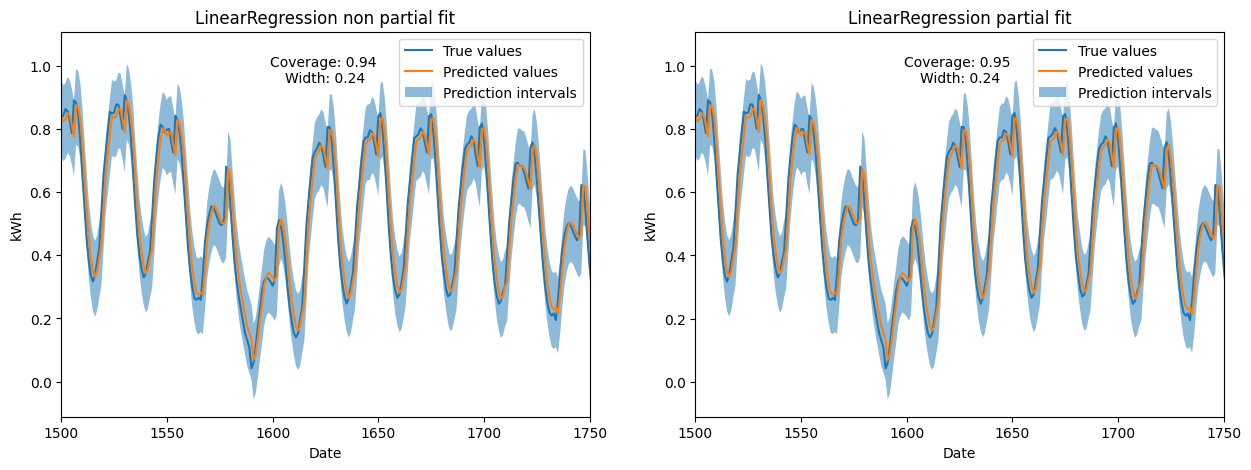

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(y_test.index, y_test, label="True values")
ax1.plot(y_test.index, y_pred_npfit, label="Predicted values")
ax1.fill_between(
    y_test.index,
    y_pis_npfit[:, 0, 0],
    y_pis_npfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
)
ax1.set_title("LinearRegression non partial fit")
ax1.text(
    0.5,
    0.9,
    f"Coverage: {round(coverage_npfit,2 )} \nWidth: {round(width_npfit,2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax1.transAxes,
)
ax1.set_xlabel("Date")
ax1.set_ylabel("kWh")
ax1.set_xlim(1500,1750)
ax1.legend()

ax2.plot(y_test.index, y_test, label="True values")
ax2.plot(y_test.index, y_pred_pfit, label="Predicted values")
ax2.fill_between(
    y_test.index,
    y_pis_pfit[:, 0, 0],
    y_pis_pfit[:, 1, 0],
    alpha=0.5,
    label="Prediction intervals",
)
ax2.set_title("LinearRegression partial fit")
ax2.text(
    0.5,
    0.9,
    f"Coverage: {round(coverage_pfit,2)} \nWidth: {round(width_pfit, 2)}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax2.transAxes,
)
ax2.set_xlabel("Date")
ax2.set_ylabel("kWh")
ax2.set_xlim(1500,1750)
ax2.legend()

In [25]:
fin = time.time()

# Calcula el tiempo transcurrido
tiempo_transcurrido = fin - inicio
print("Tiempo transcurrido: ", tiempo_transcurrido, "segundos")

Tiempo transcurrido:  230.6798620223999 segundos
